<a href="https://colab.research.google.com/github/sangttruong/ForecastMethod/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Methods for Time-series Forecasting**
*Author: Sang Truong*

Department of Economics and Management

DePauw University, Greencastle, IN 46135

* Baseline Sinusoidal Model
* Dynamic Harmonic Regressor
* State-Space Exponential Smoothing
* k-Nearest Neighbor Regressor
* Support Vector Regressor
* Recurrent Neural Network

Reference: https://otexts.com/fpp2/transformations.html

## **Section 1. Introduction**

The data is recorded over 5 years: from the begining of 2013 to the end of 2017. We observe a annual seasional period in the data as shown in the below graph. In addition, base on PACF plot, there are a weekly seasional correlation.

In [2]:
# Colab
#----------------------------------------------------------------------------------------------------------------------
from google.colab import drive
drive.mount('/content/gdrive')
path = 'gdrive/My Drive/Colab Notebooks/Forecast/'

# System
#----------------------------------------------------------------------------------------------------------------------
import time
import os, sys

# Scientific computing and database
#----------------------------------------------------------------------------------------------------------------------
import math
import pandas as pd
import numpy as np
from scipy.optimize import leastsq # Least square optimizer

# Visualization
#----------------------------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt # Plot
import seaborn as sns # Heatmap
from statsmodels.tsa.seasonal import seasonal_decompose # Seasional decomposition
import statsmodels.graphics.tsaplots as tsaplots # Residual Diagnostic

import statsmodels.tsa.stattools as stattools

# Supress output of installation
#----------------------------------------------------------------------------------------------------------------------
from contextlib import contextmanager
import os, sys
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try: yield
        finally: sys.stdout = old_stdout
            
with suppress_stdout():
  # Auto SARIMAX
  import statsmodels.tsa.statespace.sarimax as sarimax
  ! pip install pyramid-arima
  from pyramid.arima import auto_arima

  # Auto State-Space Exponential Smoothing
  ! pip install tbats
  from tbats import TBATS, BATS

# Alarm
#----------------------------------------------------------------------------------------------------------------------
def alarm():
  # Play an audio beep. Any audio URL will do.
  from google.colab import output
  output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

# Residual diagnostics
#----------------------------------------------------------------------------------------------------------------------
# Source: https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.mlemodel.MLEResults.plot_diagnostics.html
def plot_diagnostics(self, variable=0, lags=40, fig=None, figsize=(15,7)):
  from statsmodels.graphics.utils import _import_mpl, create_mpl_fig
  _import_mpl()
  fig = create_mpl_fig(fig, figsize)

  # # Eliminate residuals associated with burned or diffuse likelihoods
  # d = np.maximum(self.loglikelihood_burn, self.nobs_diffuse)
  # resid = self.filter_results.standardized_forecasts_error[variable, d:]
  # loglikelihood_burn: the number of observations during which the likelihood is not evaluated.

  # Standardize residual
  # Source: https://alkaline-ml.com/pmdarima/1.1.1/_modules/pmdarima/arima/arima.html
  resid = self
  resid = (resid - np.nanmean(resid)) / np.nanstd(resid)

  # Top-left: residuals vs time
  ax = fig.add_subplot(221)
  if hasattr(self.data, 'dates') and self.data.dates is not None:
      x = self.data.dates[d:]._mpl_repr()
  else:
      x = np.arange(len(resid))
  ax.plot(x, resid)
  ax.hlines(0, x[0], x[-1], alpha=0.5)
  ax.set_xlim(x[0], x[-1])
  ax.set_title('Standardized residual')

  # Top-right: histogram, Gaussian kernel density, Normal density
  # Can only do histogram and Gaussian kernel density on the non-null
  # elements
  resid_nonmissing = resid[~(np.isnan(resid))]
  ax = fig.add_subplot(222)

  # gh5792: Remove  except after support for matplotlib>2.1 required
  try:
      ax.hist(resid_nonmissing, density=True, label='Hist')
  except AttributeError:
      ax.hist(resid_nonmissing, normed=True, label='Hist')

  from scipy.stats import gaussian_kde, norm
  kde = gaussian_kde(resid_nonmissing)
  xlim = (-1.96*2, 1.96*2)
  x = np.linspace(xlim[0], xlim[1])
  ax.plot(x, kde(x), label='KDE')
  ax.plot(x, norm.pdf(x), label='N(0,1)')
  ax.set_xlim(xlim)
  ax.legend()
  ax.set_title('Histogram plus estimated density')

  # Bottom-left: QQ plot
  ax = fig.add_subplot(223)
  from statsmodels.graphics.gofplots import qqplot
  qqplot(resid_nonmissing, line='s', ax=ax)
  ax.set_title('Normal Q-Q')

  # Bottom-right: Correlogram
  ax = fig.add_subplot(224)
  from statsmodels.graphics.tsaplots import plot_pacf
  plot_pacf(resid, ax=ax, lags=lags)
  ax.set_title('Partial Autocorrelation function')
 
  ax.set_ylim(-0.1, 0.1)

  return fig

# Import data
#----------------------------------------------------------------------------------------------------------------------
raw = pd.read_csv(path + 'train.csv')
raw11 = raw[(raw.store == 1) & (raw.item == 1) ]
raw11
N = round(len(raw11)*0.9) # N is the length of training set

t = np.linspace(1, len(raw11), len(raw11))
t_train = t[:N,]
t_test = t[N:,]

train11 = raw11.iloc[:N,]
test11 = raw11.loc[N:,]

train11

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyramid/__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision 

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
1638,2017-06-27,1,1,32
1639,2017-06-28,1,1,50
1640,2017-06-29,1,1,28
1641,2017-06-30,1,1,28


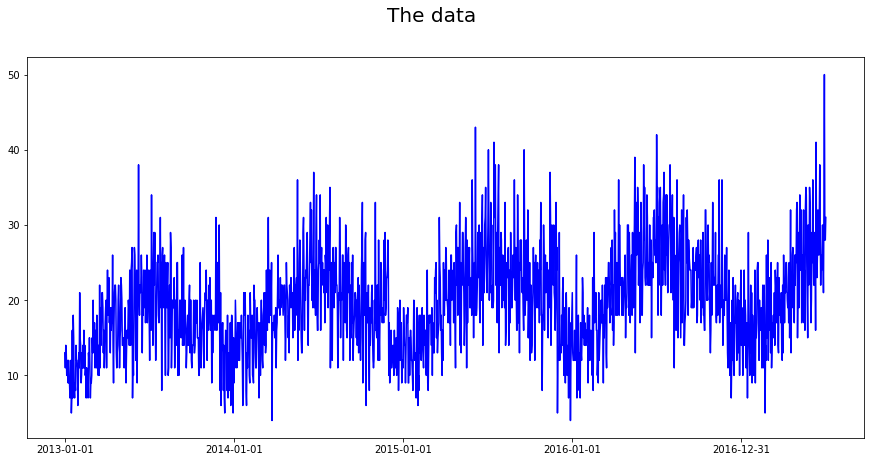

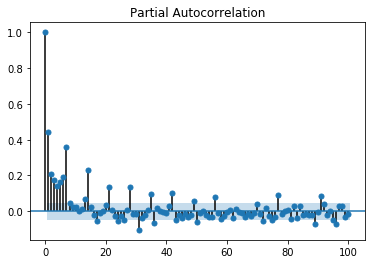

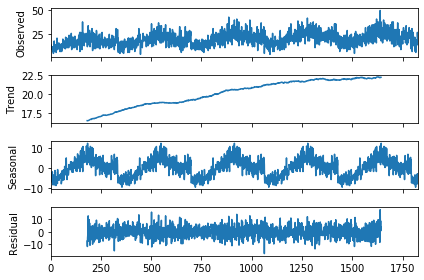

In [3]:
# Plot
plt.figure(figsize = (15,7))
plt.plot(train11.loc[:,'date'], train11.loc[:,'sales'], color='blue')
plt.xticks(np.arange(0, N, 365))
plt.suptitle('The data', fontsize = 20)
plt.savefig(path + 'Data.jpg', dpi = 500)
plt.show()

# PACF
pacf = tsaplots.plot_pacf(train11.sales, lags = 100)
pacf.savefig(path + 'pacf.jpg', dpi = 500)
pacf.show()

# Decomposition
# STL decomposition: https://github.com/jrmontag/STLDecompose/blob/master/STL-usage-example.ipynb
# STL decomposition 2: https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html
decompose = seasonal_decompose(raw11.sales, model='addictive', freq=365)
decomposeplot = decompose.plot()
decomposeplot.savefig(path + 'decomposeplot.jpg', dpi = 500)
decomposeplot.show()

## **Section 2. Sinusoidal**

We explore the forecastability of sinusoidal model (instead of random walk model) as the baseline for forecasting in this paper. Sinusodal model includes the trend component and the seasionality component:

$$ y = \alpha_{0} + \alpha_{1}t + \alpha_{2}sin(\alpha_{3}t + \alpha_{4})$$

We fit this model through the data by minimizing the sum of squared residual (SSE): 

$$ e_i = y_i - \hat{y_i} $$
$$ SSE = \sum_{i=1}^{k} e_i^2$$

rmse_train_sin 5.27742439786584
rmse_test_sin 6.148960372350588
mape_train_sin 25.022306102793426
mape_test_sin 26.960990666325614


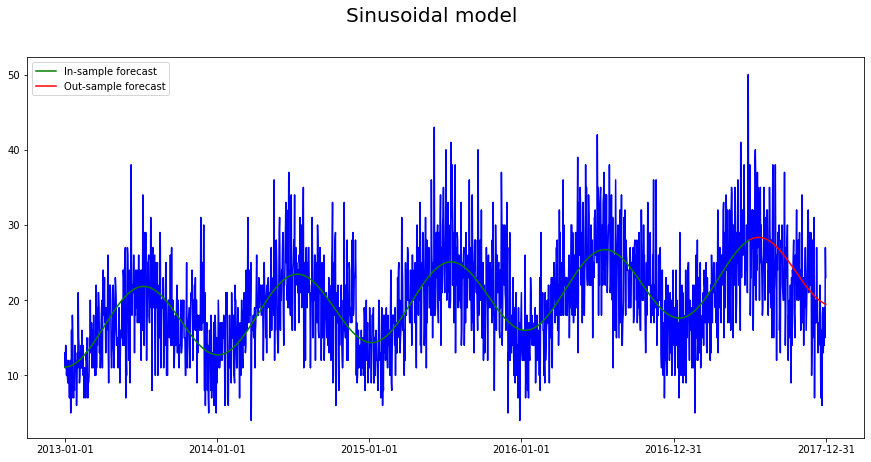

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: FutureWarning: Series.data is deprecated and will be removed in a future version


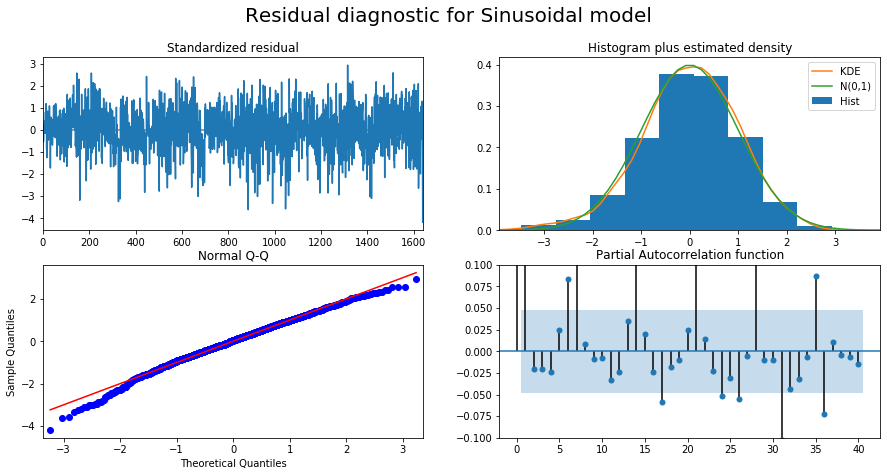

In [4]:
# Generate guest parameters
guess_int = 10
guess_trend = 0.1

guess_amp = 5
guess_freq = 2*3.14/365
guess_phase = 1

# Model configuration and optimization
residual = lambda x: train11['sales'] - (x[0] + x[1]*t_train + x[2]*np.sin(x[3]*t_train + x[4]))
result = leastsq(residual, [guess_int, guess_trend, guess_amp, guess_freq, guess_phase], full_output=1)
est_int, est_trend, est_amp, est_freq, est_phase = result[0]

# Forecast
insample_forecast_sin = (est_int+ est_trend*t_train) + est_amp*np.sin(est_freq*t_train + est_phase)
outsample_forecast_sin =  (est_int+ est_trend*t_test) + est_amp*np.sin(est_freq*t_test + est_phase)

# Error
rmse_train_sin = math.sqrt(sum((insample_forecast_sin-train11.sales)**2)/N) #5.357423907854065
rmse_test_sin = math.sqrt(sum((outsample_forecast_sin-test11.sales)**2)/(len(raw11)-N)) #6.148960372350588
mape_train_sin = 100*sum(abs((insample_forecast_sin-train11.sales)/train11.sales))/N #25.022306102793426
mape_test_sin = 100*sum(abs((outsample_forecast_sin-test11.sales)/test11.sales))/(len(raw11)-N) #26.960990666325614

print('rmse_train_sin', rmse_train_sin)
print('rmse_test_sin', rmse_test_sin)
print('mape_train_sin', mape_train_sin)
print('mape_test_sin', mape_test_sin)

# Plot
plt.figure(figsize=(15,7))
plt.plot(raw11.date, raw11.sales, color='blue')
plt.plot(insample_forecast_sin, label='In-sample forecast', color='green')
plt.plot(test11.date, outsample_forecast_sin, label = 'Out-sample forecast', color='red')
plt.xticks(np.arange(0, len(raw11), 365))
plt.legend()
plt.suptitle('Sinusoidal model', fontsize = 20)
plt.savefig(path + 'Sin.jpg', dpi = 500)
plt.show()

# Residual diagnostic
resdiag_sin = plot_diagnostics(insample_forecast_sin-train11.sales)
plt.suptitle('Residual diagnostic for Sinusoidal model', fontsize = 20)
resdiag_sin.savefig(path + 'resid_sin.jpg', dpi = 500)
resdiag_sin.show()

## **Section 3. DHR**

Dynamic harmonic regression with multiple seasonal periods:
* [Rob Hyndman lecture](https://robjhyndman.com/nyc2018/3-1-Dynamic-Regression.pdf)
* [Rob Hyndman textbook chapter](https://otexts.com/fpp2/dhr.html)

Seasional ARIMA (or SARIMA) model includes 7 parameters: p, d, q, P, D, Q, and s. SARIMA(p, d, q)(P, D, Q)s is determined by four following polynomials: 
$$\phi(x) = 1 - \phi_{1}x - \phi_{2}x^2- \phi_{3}x^3 - ... - \phi_{p}x^p = 1 - \sum_{i=1}^{p}\phi_i x^i $$
$$\Phi(x) = 1 - \Phi_{1}x - \Phi_{2}x^2- \Phi_{3}x^3 - ... - \Phi_{p}x^P = 1 - \sum_{i=1}^{P}\Phi_i x^i $$
$$\psi(x) = 1 - \psi_{1}x - \psi_{2}x^2- \psi_{3}x^3 - ... - \psi_{q}x^p = 1 - \sum_{i=1}^{q}\psi_i x^i $$
$$\Psi(x) = 1 - \Psi_{1}x - \Psi_{2}x^2- \Psi_{3}x^3 - ... - \Psi_{Q}x^p = 1 - \sum_{i=1}^{Q}\Psi_i x^i $$

Recall the differential notation for trend-stationalizing time-series:
$$ \nabla_s Y_t = Y_t - Y_{t-s} $$

SARIMA(p, d, q)(P, D, Q)s where $X_t$ is the white noise process:
$$\phi(B)\Phi(B)\nabla^d \nabla_s^D Y_{t} = \psi(B)\Psi(B)X_{t} $$

Note that SARIMA can only model 1 seasional period (by parameter $s$).

When exogenous regressors are included, the [SARIMAX](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html) module uses the concept of “regression with SARIMA errors”. 

In [5]:
# Generate Fourier's term for training set
fourier_train = pd.DataFrame({'date': pd.to_datetime(train11['date'])})
fourier_train = fourier_train.set_index(pd.PeriodIndex(fourier_train.date.values, freq='D'))
for i in range(1,16):
  fourier_train['sin365_' + str(i)] = np.sin(2 * i * np.pi * fourier_train.index.dayofyear / 365.25)
  fourier_train['cos365_' + str(i)] = np.cos(2 * i * np.pi * fourier_train.index.dayofyear / 365.25)
fourier_train.head()

# Generate Fourier's term for testing set
fourier_test = pd.DataFrame({'date': pd.to_datetime(test11['date'])})
fourier_test = fourier_test.set_index(pd.PeriodIndex(fourier_test.date.values, freq='D'))
for i in range(1,16):
  fourier_test['sin365_' + str(i)] = np.sin(2 * i * np.pi * fourier_test.index.dayofyear / 365.25)
  fourier_test['cos365_' + str(i)] = np.cos(2 * i * np.pi * fourier_test.index.dayofyear / 365.25)

# Hyperparameter K turning
DHR = pd.DataFrame(columns = ['K', 'Result', 'AIC'])
for i in range(10,11):
  f_train = fourier_train.iloc[:,1:(2*i+1)]
  DHR.loc[i, 'K'] = i
  DHR.loc[i,'Result'] = auto_arima(y = train11['sales'], exogenous = f_train, seasonal = True, m = 7, suppress_warnings = True)
  DHR.loc[i, 'AIC'] = DHR.loc[i,'Result'].aic()
  print(DHR)

# plt.figure(figsize = (10,5))
# plt.plot(DHR.K, DHR.AIC)
# plt.xlabel('K')
# plt.ylabel('AIC')
# plt.suptitle('Hyperparameter (K) turning for Dynamic Harmonic Regression', fontsize = 20)
# plt.savefig(path + 'KturningDHR.jpg', dpi = 500)
# plt.show()

     K                                             Result      AIC
10  10  ARIMA(callback=None, disp=0, maxiter=50, metho...  9648.75


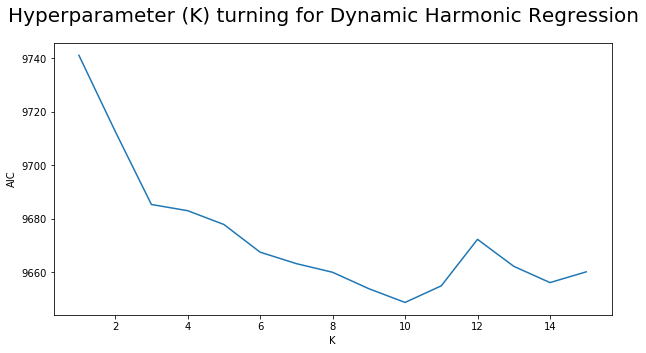

In [6]:
DHRK = np.arange(1,16,1)
DHRAIC = [9741.12	, 9712.74	, 9685.37	, 9683.05	, 9677.9	, 9667.55	, 9663.26	, 9660.03	, 9653.89	, 9648.75	, 9654.96	, 9672.34	, 9662.26	, 9656.17	, 9660.19]

plt.figure(figsize = (10,5))
plt.plot(DHRK, DHRAIC)
plt.xlabel('K')
plt.ylabel('AIC')
plt.suptitle('Hyperparameter (K) turning for Dynamic Harmonic Regression', fontsize = 20)
plt.savefig(path + 'KturningDHR.jpg', dpi = 500)
plt.show()

rmse_train_DHR 4.5044196406658665
rmse_test_DHR 4.900916628354385
mape_train_DHR 20.855284987286474
mape_test_DHR 21.414172200211617


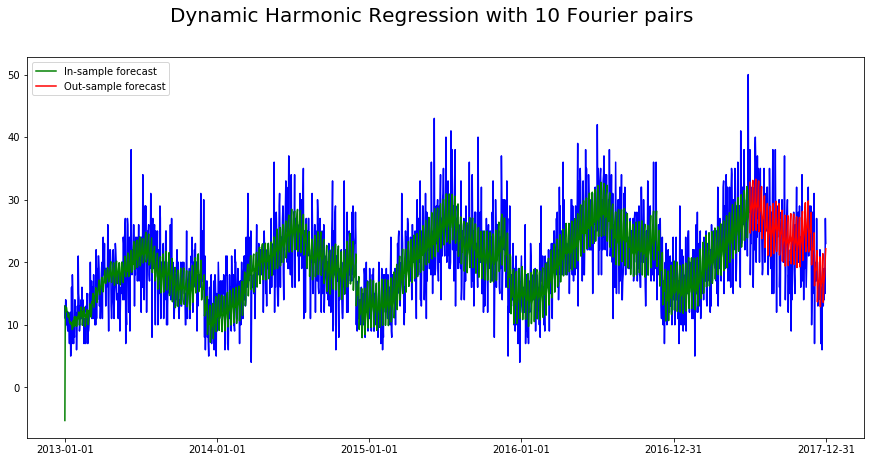

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                 1643
Model:             SARIMAX(1, 1, 1)x(2, 0, 2, 7)   Log Likelihood               -4796.376
Date:                           Wed, 05 Feb 2020   AIC                           9648.751
Time:                                   16:44:33   BIC                           9800.054
Sample:                                        0   HQIC                          9704.862
                                          - 1643                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.944e-06   2.14e-05      0.137      0.891   -3.91e-05     4.5e-05
x1            -1.5078      0.241     -6.254

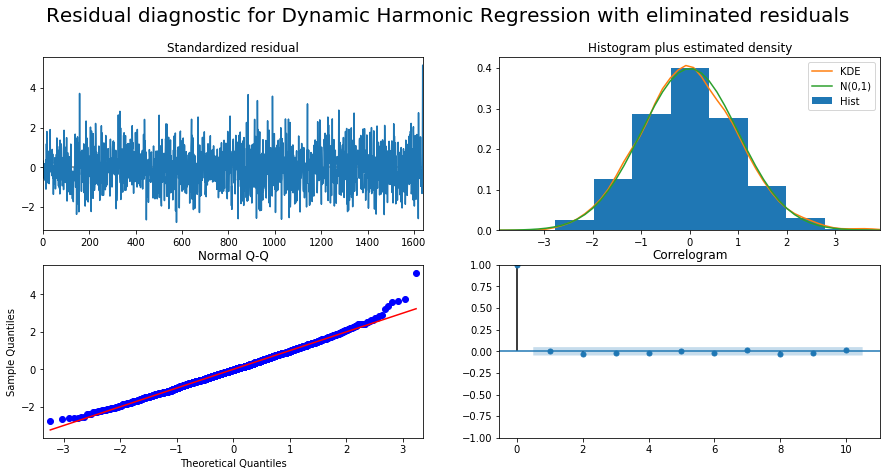

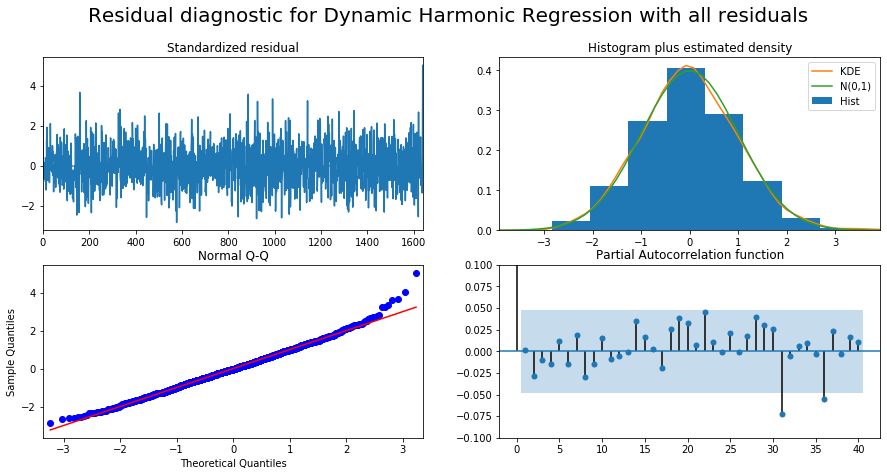

In [7]:
# (Recalled) Model configuration and optimization
i = 10 # SARIMAX, K = 10 is the best model
f_train = fourier_train.iloc[:,1:(2*i+1)]
f_test = fourier_test.iloc[:,1:(2*i+1)]

# Forecast
insample_forecast_DHR = DHR.loc[i,'Result'].predict_in_sample(f_train)
outsample_forecast_DHR = DHR.loc[i,'Result'].predict(len(raw11)-N, f_test)

# Error
rmse_train_DHR = math.sqrt(sum((insample_forecast_DHR-train11.sales)**2)/N) #4.5044196406658665
rmse_test_DHR = math.sqrt(sum((outsample_forecast_DHR-test11.sales)**2)/(len(raw11)-N)) #4.900916628354385
mape_train_DHR = 100*sum(abs((insample_forecast_DHR-train11.sales)/train11.sales))/N #
mape_test_DHR = 100*sum(abs((outsample_forecast_DHR-test11.sales)/test11.sales))/(len(raw11)-N) #

print('rmse_train_DHR', rmse_train_DHR)
print('rmse_test_DHR', rmse_test_DHR)
print('mape_train_DHR', mape_train_DHR)
print('mape_test_DHR', mape_test_DHR)

# Plot
plt.figure(figsize=(15,7))
plt.plot(raw11.date, raw11.sales, color = 'blue')
plt.plot(train11.date, insample_forecast_DHR, label = 'In-sample forecast', color = 'green')
plt.plot(test11.date, outsample_forecast_DHR, label = 'Out-sample forecast', color = 'red')
plt.legend()
plt.xticks(np.arange(0, len(raw11), 365))
plt.suptitle('Dynamic Harmonic Regression with 10 Fourier pairs', fontsize = 20)
plt.savefig(path + 'DHR_K=10.jpg', dpi = 500)
plt.show()

# Model summary
print(DHR.loc[i,'Result'].summary())

# Residual diagnostic with eliminated residuals associated with burned or diffuse likelihoods
f_train = f_train.reset_index(drop = True)
import statsmodels.tsa.statespace.sarimax as sarimax
DHR2 = sarimax.SARIMAX(train11.sales, exog = f_train, order=(1, 1, 1), seasonal_order=(2, 0, 2, 7), )
DHR2 = DHR2.fit()
DHR2.plot_diagnostics(figsize=(15, 7))
plt.suptitle('Residual diagnostic for Dynamic Harmonic Regression with eliminated residuals', fontsize = 20)
plt.savefig(path + 'resid_DHR_eliminatedResid.png', quality = 100, dpi = 1000)
plt.show()

# Residual diagnostic with all residual
plot_diagnostics(DHR.loc[i,'Result'].resid())
plt.suptitle('Residual diagnostic for Dynamic Harmonic Regression with all residuals', fontsize = 20)
plt.savefig(path + 'resid_DHR_allResid.jpg', dpi = 500)
plt.show()

## **Section 4. TBATS**
[TBATS Documentation](https://pypi.org/project/tbats/)

rmse_train_TBATS 4.476060861375845
rmse_test_TBATS 4.709578222905581
mape_train_TBATS 20.720463030903414
mape_test_TBATS 20.06172475636418


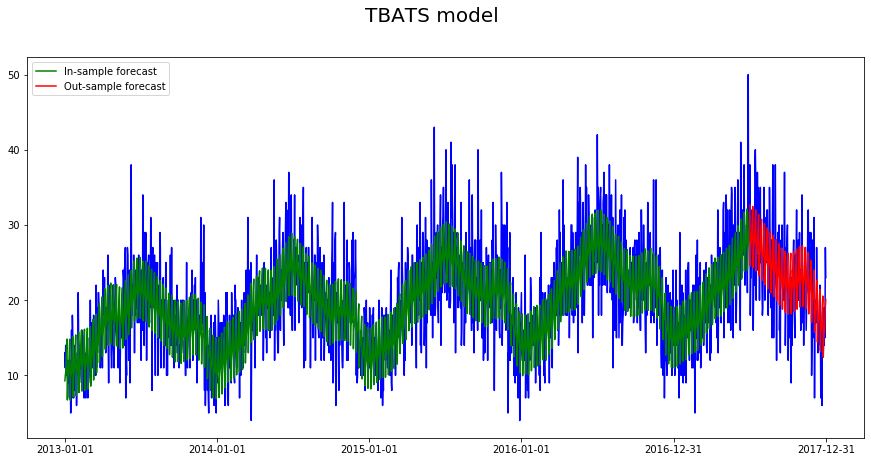

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [  7.   365.25]
Seasonal harmonics [3 5]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 0.021433
Seasonal Parameters (Gamma): [6.76205557e-09 1.52984727e-08 6.31671864e-10 9.56033709e-09]
AR coefficients []
MA coefficients []
Seed vector [ 1.73515005e+01 -2.60622319e+00 -2.91681871e-01  1.21111329e+00
 -7.15308899e-01  1.82823019e+00  8.97730041e-01 -4.79700119e+00
  2.18630194e-03 -1.05111669e+00 -1.04472647e-01 -4.41500950e-01
 -9.43133873e-01 -1.00299772e+00 -6.12672101e-01  2.58632288e-01
  4.44877906e-01]

AIC 17134.101363


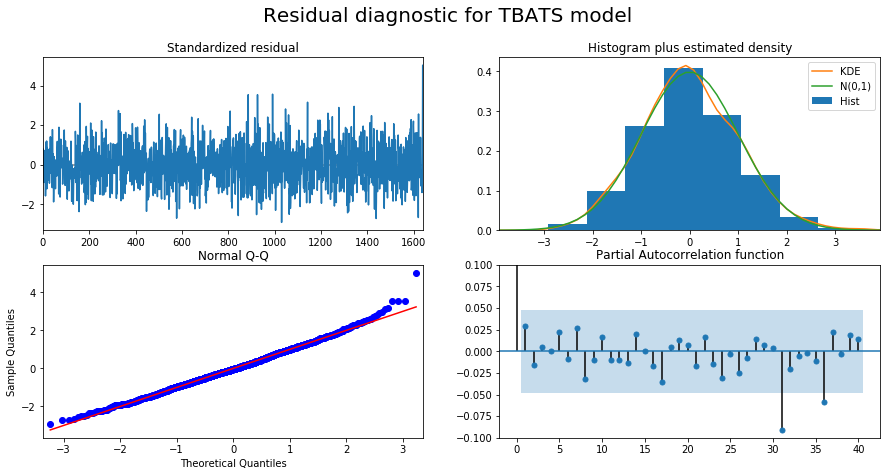

In [8]:
# Model configuration and optimization
TBATS_estimator = TBATS(use_box_cox = None, use_trend = None, use_damped_trend = None, seasonal_periods=(7, 365.25), use_arma_errors = True)
TBATS_result = TBATS_estimator.fit(train11.sales)

# Forecast
insample_forecast_TBATS = TBATS_result.y_hat
outsample_forecast_TBATS = TBATS_result.forecast(steps=len(raw11)-N)

# Error
rmse_train_TBATS = math.sqrt(sum((insample_forecast_TBATS-train11.sales)**2)/N) #4.476060861375845
rmse_test_TBATS = math.sqrt(sum((outsample_forecast_TBATS-test11.sales)**2)/(len(raw11)-N)) #4.709578222905581
mape_train_TBATS = 100*sum(abs((insample_forecast_TBATS-train11.sales)/train11.sales))/N #
mape_test_TBATS = 100*sum(abs((outsample_forecast_TBATS-test11.sales)/test11.sales))/(len(raw11)-N) #

# For seasonal_periods=(7, 31, 365):
  # rmse_train_TBATS 4.450088400872355
  # rmse_test_TBATS 4.7602603980889

print('rmse_train_TBATS', rmse_train_TBATS)
print('rmse_test_TBATS', rmse_test_TBATS)
print('mape_train_TBATS', mape_train_TBATS)
print('mape_test_TBATS', mape_test_TBATS)

# Plot
plt.figure(figsize=(15,7))
plt.plot(raw11.date, raw11.sales, color = 'blue')
plt.plot(train11.date, insample_forecast_TBATS, label = 'In-sample forecast', color = 'green')
plt.plot(test11.date, outsample_forecast_TBATS, label = 'Out-sample forecast', color = 'red')
plt.legend()
plt.xticks(np.arange(0, len(raw11), 365))
plt.suptitle('TBATS model', fontsize = 20)
plt.savefig(path + 'TBATS.jpg', dpi = 500)
plt.show()

# Model summary
print(TBATS_result.summary())

# Residual diagnostic
plot_diagnostics(TBATS_result.resid)
plt.suptitle('Residual diagnostic for TBATS model', fontsize = 20)
plt.savefig(path + 'resid_TBATS.jpg', dpi = 500)
plt.show()

## **Section 5. KNN**

Note: 
Try KNN implemented in R tsfknn: 
* https://github.com/franciscomartinezdelrio/tsfknn/blob/master/R/forecasting.R
* https://cran.r-project.org/web/packages/tsfknn/vignettes/tsfknn.html

* International symposium in forecasting: https://www.lancaster.ac.uk/lums/news/presentations-from-the-international-symposium-on-forecasting-2018

In [0]:
'''
Hyperparameters of k-Nearest Neighbor Regression include:
* wsize: number of lag to look back
* k: number of similar neighbors
* Minkowski_p: Minkowski distance power. p = 1 is Manhattan, p = 2 is Eucledian. p can be between 1 and 2. 
'''

class KNNRegressor():
  import numpy as np
  def __init__(self, wsize = 10, Minkowski_p = 2, k = 10, step=1):
    self.inputTS = None
    self.wsize = wsize
    self.Minkowski_p = Minkowski_p
    self.k = k
    self.step = step

  # Forecast function
  #----------------------------------------------------------------------------------------------------------------------
  def forecast(self, inputTS, seq=False):
    inputTS = np.array(inputTS)

    # Slide the window of wsize
    n = len(inputTS)
    windows = []
    for i in range(n - self.wsize + 1):
      windows.append(inputTS[i : i + self.wsize])

    # Take the most recent window ...
    recentTS = windows[-1]
    recentTS = np.array(recentTS).reshape((1,self.wsize))
    # ... and compare with previous window
    from scipy.spatial import distance
    df = pd.DataFrame(columns=['i_forecast', 'dist'])
    u = distance.cdist(windows[:-1], recentTS, 'minkowski', p = self.Minkowski_p)
    df.dist = u.flatten()
    for j in range(len(windows) - 1):
      df.loc[j, 'i_forecast'] = inputTS[ j + self.wsize]
    df.sort_values(by = ['dist'], inplace = True)
    forecast = np.mean(df.iloc[0:self.k, 0])

    # def mean_confidence_interval(inputTS, confidence=0.95):
    #   import scipy.stats
    #   a = 1.0 * np.array(inputTS)
    #   n = len(a)
    #   m, se = np.mean(a), scipy.stats.sem(a)
    #   h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    #   return m-h, m+h
    
    # ci = mean_confidence_interval(forecast)  
    # return forecast, ci[0], ci[1]
    return forecast

# Decay distance
'''
The only issue with decay distance function is that it is tricky to find a set of suitable weight.
For this particular series, we observe that weight distance performs much worse than average distance.
'''
#----------------------------------------------------------------------------------------------------------------------
# Match to levels distance
def match_levels(x1, x2):
  x1 = np.array(x1)
  x2 = np.array(x1)
  w = np.array([1/(i+1) for i in range(len(x1))])
  dist = np.sum(np.multiply(w,(x2-x1)**2))
  return dist

# Match to deviations from local mean
def match_dev_local(x1, x2):
  x1 = np.array(x1)
  x2 = np.array(x1)
  x1_dev = x1[i] - x1.mean()
  x2_dev = x2[i] - x2.mean()
  w = np.array([1/(i+1) for i in range(len(x1))])
  dist = np.sum(np.multiply(w,(x2_dev-x1_dev)**2))
  return dist

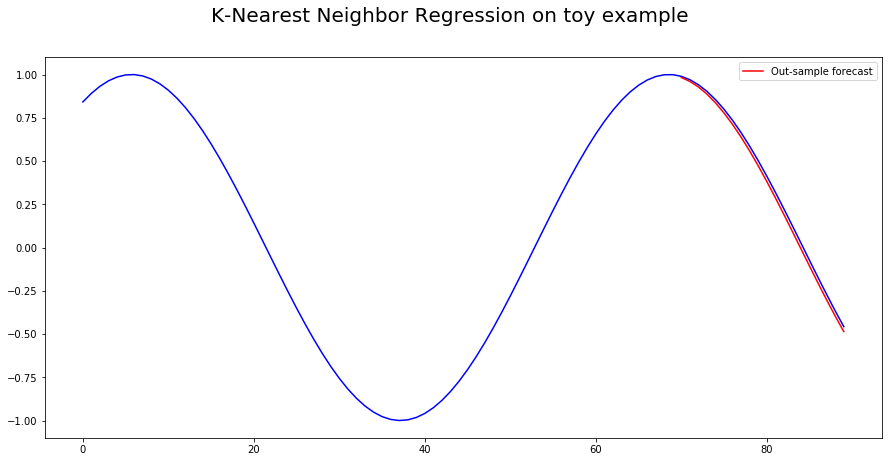

In [10]:
'''
To test k-nearest neighbor regressor, we apply the algorithm on a toy example
'''
# Generate data
x = np.arange(1,10,0.1)
y = np.sin(x)

# Model configuration
wsize = 5
k = 2
nnm = KNNRegressor(wsize = wsize, k = k, Minkowski_p=2)

# Forecasting
preds = pd.DataFrame(columns=['raw', 'trainKNN', 'KNN'])
preds.raw = y
preds.loc[0:70,'trainKNN'] = y[0:71]
for i in range (70, len(y)):
  x_input = preds.loc[:i-1,'trainKNN']
  preds.loc[i,'trainKNN'] = preds.loc[i,'KNN'] = nnm.forecast(x_input)

# Plot
plt.figure(figsize=(15,7))
plt.plot(preds.raw, color = 'blue')
plt.plot(preds.KNN, color = 'red', label = 'Out-sample forecast')
plt.legend()
plt.suptitle('K-Nearest Neighbor Regression on toy example', fontsize = 20)
plt.show()

rmse_grid        365
7  4.82972
mape_grid        365
7  19.1073


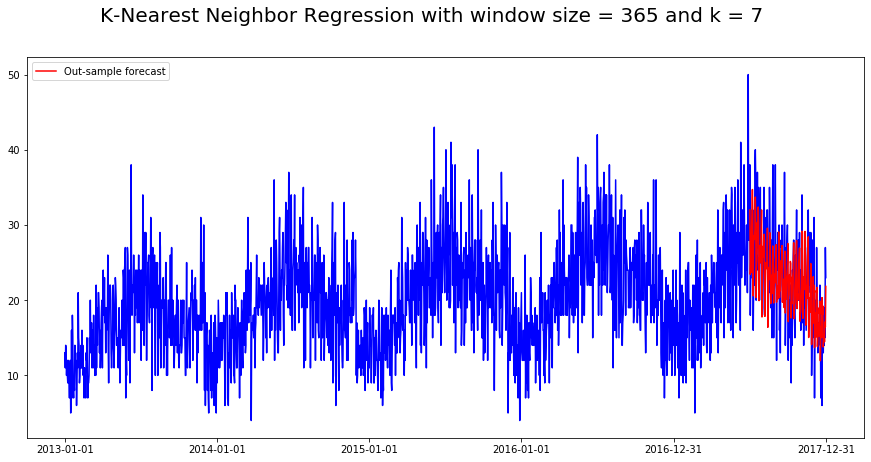

In [11]:
'''
Vanila KNN
'''

# Hyperparameters wsize and k turning
WSIZE = [365]
K = [7]
rmse_grid = pd.DataFrame(index=K, columns=WSIZE)
mape_grid = pd.DataFrame(index=K, columns=WSIZE)

for wsize in WSIZE:
  for k in K:

    # Model configuration
    nnm = KNNRegressor(wsize = wsize, k = k, Minkowski_p = 2)
    preds = pd.DataFrame(columns=['date', 'raw11', 'trainKNN', 'KNN'])
    preds.date = raw11.date
    preds.raw11 = raw11.sales
    preds.loc[0:N-1,'trainKNN'] = train11.sales

    # Forecasting
    for i in range (N, len(raw11)):
      x_input = preds.loc[:i-1,'trainKNN']
      preds.loc[i,'trainKNN'] = preds.loc[i,'KNN'] = nnm.forecast(x_input)

    # Error
    rmse_grid.loc[k, wsize] = math.sqrt(sum((preds.loc[N:,'KNN']-test11.sales)**2)/(len(raw11)-N))
    mape_grid.loc[k, wsize] = 100*sum(abs((preds.loc[N:,'KNN']-test11.sales)/test11.sales))/(len(raw11)-N) #
    print('rmse_grid', rmse_grid)
    print('mape_grid', mape_grid)

outsample_forecast_KNN = preds.loc[N:,'KNN']

# Plot
plt.figure(figsize=(15,7))
plt.plot(raw11.date, raw11.sales, color = 'blue')
plt.plot(test11.date, preds.loc[N:,'KNN'], label= 'Out-sample forecast', color = 'red')
plt.legend()
plt.xticks(np.arange(0, len(raw11), 365))
plt.suptitle('K-Nearest Neighbor Regression with window size = 365 and k = 7', fontsize = 20)
plt.savefig(path + 'KNN_wsize=365_k=7.jpg', dpi = 500)
plt.show()

# wsize = 365, k = 365, error = 5.96871, p = 2
# --- 127.03262233734131 seconds ---

# wsize = 365, k = 7, error = 4.82972, p = 2
# --- 126.49110531806946 seconds ---

# wsize = 365, k = 7, error = 4.92251, p = 1
# --- 128.55719137191772 seconds ---

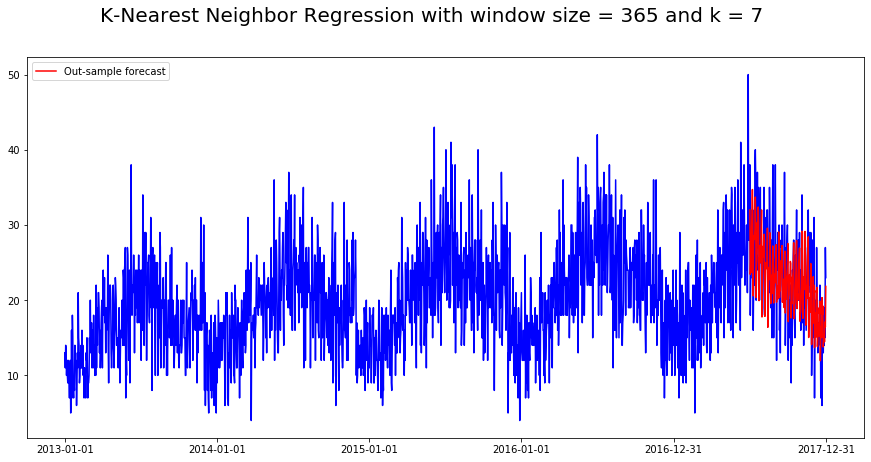

In [12]:
# Plot
plt.figure(figsize=(15,7))
plt.plot(raw11.date, raw11.sales, color = 'blue')
plt.plot(test11.date, preds.loc[N:,'KNN'], label= 'Out-sample forecast', color = 'red')
plt.legend()
plt.xticks(np.arange(0, len(raw11), 365))
plt.suptitle('K-Nearest Neighbor Regression with window size = 365 and k = 7', fontsize = 20)
plt.savefig(path + 'KNN_wsize=365_k=7.jpg', dpi = 500)
plt.show()

rmse_grid       365
7  5.1182
mape_grid        365
7  22.8841


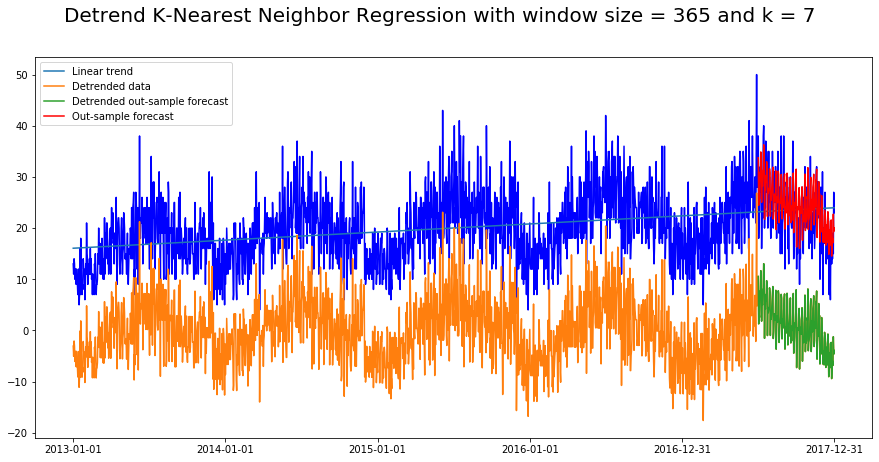

In [13]:
'''
Detrend-KNN
'''
# Detrend
import statsmodels.api as sm
y_train11 = train11.sales
y_raw11 = raw11.sales

x_train11 = np.arange(1,len(train11)+1)
x_train11 = sm.add_constant(x_train11)

x_raw11 = np.arange(1,len(raw11)+1)
x_raw11 = sm.add_constant(x_raw11)

model = sm.OLS(y_train11,x_train11)
results = model.fit()

yhat_train11 = results.predict(x_train11)
yhat_raw11 = results.predict(x_raw11)
detrend_train11 = y_train11 - yhat_train11

# Hyperparameters wsize and k turning
WSIZE = [365]
K = [7]
rmse_grid = pd.DataFrame(index=K, columns=WSIZE)
mape_grid = pd.DataFrame(index=K, columns=WSIZE)

for wsize in WSIZE:
  for k in K:
    # Model configuration
    nnm = KNNRegressor(wsize = wsize, k = k)

    # Forecasting
    preds = pd.DataFrame(columns=['date', 'raw11', 'trend', 'detrend_train11', 'KNN'])
    preds.date = raw11.date
    preds.raw11 = raw11.sales
    preds.trend = yhat_raw11
    preds.loc[0:N-1,'detrend_train11'] = detrend_train11

    for i in range (N, len(raw11)):
      x_input = preds.loc[:i-1,'detrend_train11']
      preds.loc[i,'detrend_train11'] = preds.loc[i,'KNN'] = nnm.forecast(x_input) 

    # Error
    rmse_grid.loc[k, wsize] = math.sqrt(sum((preds.loc[N:,'KNN'] + preds.loc[N:,'trend'] - preds.loc[N:,'raw11'])**2)/(len(raw11)-N))
    mape_grid.loc[k, wsize] = 100*sum(abs((preds.loc[N:,'KNN'] + preds.loc[N:,'trend'] - preds.loc[N:,'raw11'])/preds.loc[N:,'raw11']))/(len(raw11)-N) #
    print('rmse_grid', rmse_grid)
    print('mape_grid', mape_grid)

# Plot
t = preds.loc[N:,'KNN'] + preds.loc[N:,'trend']
plt.figure(figsize=(15,7))
plt.plot(raw11.date, preds.raw11, color = 'blue')
plt.plot(preds.trend, label= 'Linear trend')
plt.plot(preds.detrend_train11, label = 'Detrended data')
plt.plot(preds.KNN, label = 'Detrended out-sample forecast')
plt.plot(t, label = 'Out-sample forecast', color = 'red')
plt.suptitle('Detrend K-Nearest Neighbor Regression with window size = 365 and k = 7', fontsize = 20)
plt.legend()
plt.xticks(np.arange(0, len(raw11), 365))
plt.savefig(path + 'Detrend_KNN_wsize=365_k=7.jpg', quality = 100, dpi = 1000)
plt.show()

       365
7  4.82972
rmse_bootstrap_KNN 4.829715211229878


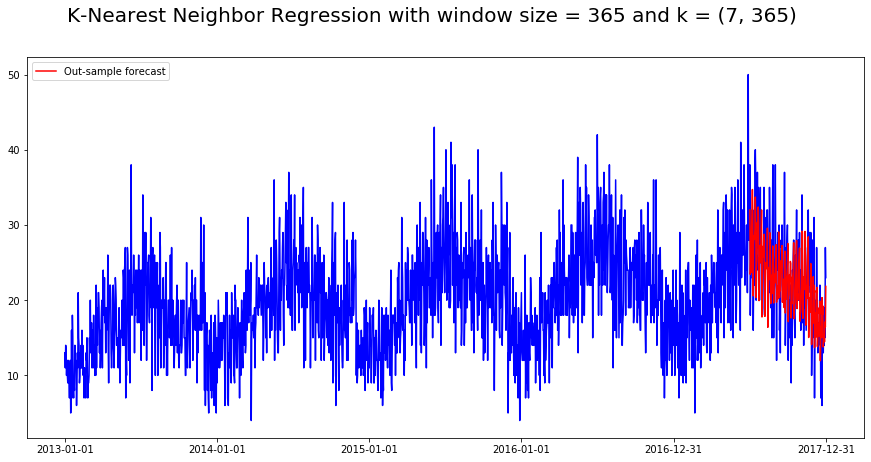

In [14]:
'''
Bootstrap KNN
'''
# Grid search: hyperparameter turning with out sample forecast
WSIZE = [365]
K = [7]
grid = pd.DataFrame(index=K, columns=WSIZE)
bootstrap = pd.DataFrame()

for wsize in WSIZE:
  for k in K:
    # Model configuration
    nnm = KNNRegressor(wsize = wsize, k = k, Minkowski_p = 2)
    preds = pd.DataFrame(columns=['date', 'raw11', 'trainKNN', 'KNN'])
    preds.date = raw11.date
    preds.raw11 = raw11.sales
    preds.loc[0:N-1,'trainKNN'] = train11.sales

    # Forecasting
    for i in range (N, len(raw11)):
      x_input = preds.loc[:i-1,'trainKNN']
      preds.loc[i,'trainKNN'] = preds.loc[i,'KNN'] = nnm.forecast(x_input)

    # Append forecast
    bootstrap = bootstrap.append(preds.loc[N:,'KNN'], ignore_index=True)

    # Error
    grid.loc[k, wsize] = math.sqrt(sum((preds.loc[N:,'KNN']-test11.loc[:,'sales'])**2)/(len(raw11)-N))
    print(grid)

# Model average
rmse_bootstrap_KNN = math.sqrt(sum((bootstrap.mean(axis=0) - preds.loc[N:,'raw11'])**2)/(len(raw11)-N))
print('rmse_bootstrap_KNN', rmse_bootstrap_KNN)

# Plot
plt.figure(figsize=(15,7))
plt.plot(raw11.date, raw11.sales, color = 'blue')
plt.plot(test11.date, bootstrap.mean(axis=0), label= 'Out-sample forecast', color = 'red')
plt.legend()
plt.xticks(np.arange(0, len(raw11), 365))
plt.suptitle('K-Nearest Neighbor Regression with window size = 365 and k = (7, 365)', fontsize = 20)
plt.savefig(path + 'KNN_wsize=365_k=(7, 365).png', quality = 100, dpi = 1000)
plt.show()

In [15]:
'''
KNN with decay distance
'''
# Grid search: hyperparameter turning with out sample forecast
WSIZE = [365]
K = [365]
grid = pd.DataFrame(index=K, columns=WSIZE)

for wsize in WSIZE:
  for k in K:
    nnm = KNNRegressor(wsize = wsize, distFunc = match_levels, k = k)
    preds = pd.DataFrame(columns=['raw11', 'trainKNN', 'KNN'])
    preds.raw11 = raw11.sales
    preds.loc[0:N-1,'trainKNN'] = train11.sales

    for i in range (N, len(raw11)):
      x_input = preds.loc[:i-1,'trainKNN']
      preds.loc[i,'trainKNN'] = nnm.forecast(x_input)  
      preds.loc[i,'KNN'] = preds.loc[i,'trainKNN']

    # Error
    grid.loc[k, wsize] = math.sqrt(sum((preds.loc[N:,'KNN']-test11.loc[:,'sales'])**2)/(len(raw11)-N))
    print(grid) # 365, 365, 5.96871

# Plot best KNN
plt.figure(figsize=(15,7))
plt.plot(raw11.date, raw11.sales, color = 'blue')
plt.plot(test11.date, preds.loc[N:,'KNN'], label='Predict out sample', color = 'red')
plt.legend()
plt.xticks(np.arange(0, len(raw11), 365))
plt.savefig(path + 'figure8KNN700_39.png', quality = 100, dpi = 1000)
plt.show()

TypeError: ignored

## **Section 6. SVR**

rmse_train_SVR 3.191482322806986
rmse_test_SVR 4.98040937772345
mape_train_SVR 10.191192761859943
mape_test_SVR 19.890162441236495


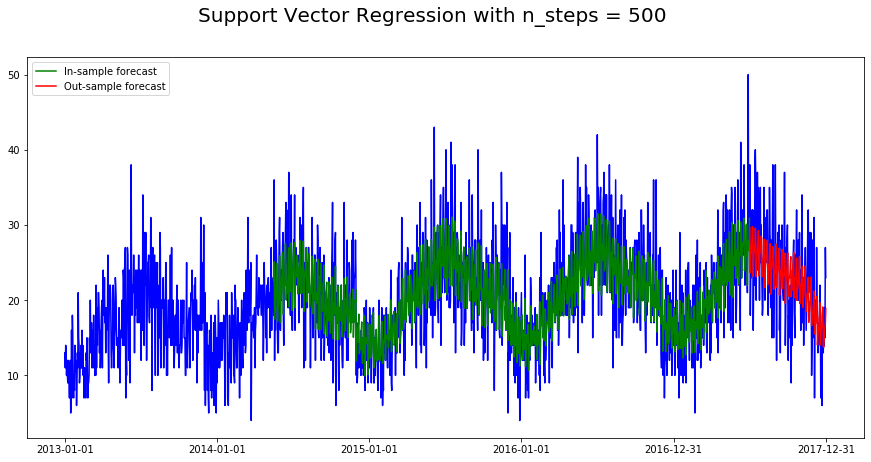

In [24]:
'''
Hyperparameters of Support Vector Regression include:
* n_steps: Number of steps to look back 
* C: Regularization parameter
* Epsilon: Epsilon in the epsilon-SVR model
'''

from numpy import array
from sklearn.svm import SVR

# Split a univariate sequence
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# Model configuration and optimization
n_steps = 500
raw_seq = train11.sales
X, y = split_sequence(raw_seq, n_steps)
svr = SVR(kernel='rbf', C=2, epsilon=0.1)
svr.fit(X, y)

# Forecast
preds = pd.DataFrame(columns=['date','raw11','inSVR', 'trainSVR', 'SVR'])
preds.date = raw11.date
preds.raw11 = raw11.sales
preds.loc[n_steps:N-1,'inSVR'] = svr.predict(X)

preds.loc[0:N-1,'trainSVR'] = train11.sales
for i in range (N-n_steps, len(raw11)-n_steps):
  x_input = np.array(preds.loc[i:i+n_steps-1,'trainSVR'])
  preds.loc[i+n_steps,'trainSVR'] = preds.loc[i+n_steps,'SVR'] = svr.predict(x_input.reshape(1,n_steps))

outsample_forecast_SVR = preds.loc[N:,'SVR']

# Error 
rmse_train_SVR = math.sqrt(sum((preds.loc[n_steps:N-1, 'inSVR']-train11.loc[n_steps:,'sales'])**2)/N) #3.191482322806986
rmse_test_SVR = math.sqrt(sum((preds.loc[N:,'SVR']-test11.sales)**2)/(len(raw11)-N)) #4.98040937772345
mape_train_SVR = 100*sum(abs((preds.loc[n_steps:N-1, 'inSVR']-train11.loc[n_steps:,'sales'])/train11.loc[n_steps:,'sales']))/N #
mape_test_SVR = 100*sum(abs((preds.loc[N:,'SVR']-test11.sales)/test11.sales))/(len(raw11)-N) #

print('rmse_train_SVR', rmse_train_SVR)
print('rmse_test_SVR', rmse_test_SVR)
print('mape_train_SVR', mape_train_SVR)
print('mape_test_SVR', mape_test_SVR)

# Plot
plt.figure(figsize=(15,7))
plt.plot(preds.date, preds.raw11, color='blue')
plt.plot(preds.inSVR, color = 'green', label='In-sample forecast')
plt.plot(preds.SVR, color = 'red', label='Out-sample forecast')
plt.legend()
plt.xticks(np.arange(0, len(raw11), 365))
plt.suptitle('Support Vector Regression with n_steps = 500', fontsize = 20)
plt.savefig(path + 'SVR_nsteps=500.jpg', dpi = 500)
plt.show()

In [0]:
# Training data is shrunk after feeding the data through SVR. Error of SVR:
eSVR = preds.raw11 - preds.inSVR
eSVR = eSVR.dropna()

## **Section 7. LSTM**
* [Understanding LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/
)
* [Implementation of LSTM](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/)


Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/100





 - 2s - loss: 408.8990
Epoch 2/100
 - 1s - loss: 133.1457
Epoch 3/100
 - 1s - loss: 45.5945
Epoch 4/100
 - 1s - loss: 48.4714
Epoch 5/100
 - 1s - loss: 45.6537
Epoch 6/100
 - 1s - loss: 36.5319
Epoch 7/100
 - 1s - loss: 38.1253
Epoch 8/100
 - 1s - loss: 40.6791
Epoch 9/100
 - 1s - loss: 39.6724
Epoch 10/100
 - 1s - loss: 35.8837
Epoch 11/100
 - 1s - loss: 38.3677
Epoch 12/100
 - 1s - loss: 34.9913
Epoch 13/100
 - 1s - loss: 34.2967
Epoch 14/100
 - 1s - loss: 35.2884
Epoch 15/100
 - 1s - loss: 34.0411
Epoch 16/100
 - 1s - loss: 33.8917
Epoch 17/100
 - 1s - loss: 32.4637
Epoch 18/100
 - 1s - loss: 32.3400
Epoch 19/100
 - 1s - loss: 31.6965
Epoch 20/100
 - 1s - loss: 32.6684
Epoch 21/100
 - 1s - loss: 33.3563
Epoch 22/100
 - 0s - loss: 35.2137
Epoch 23/100
 -

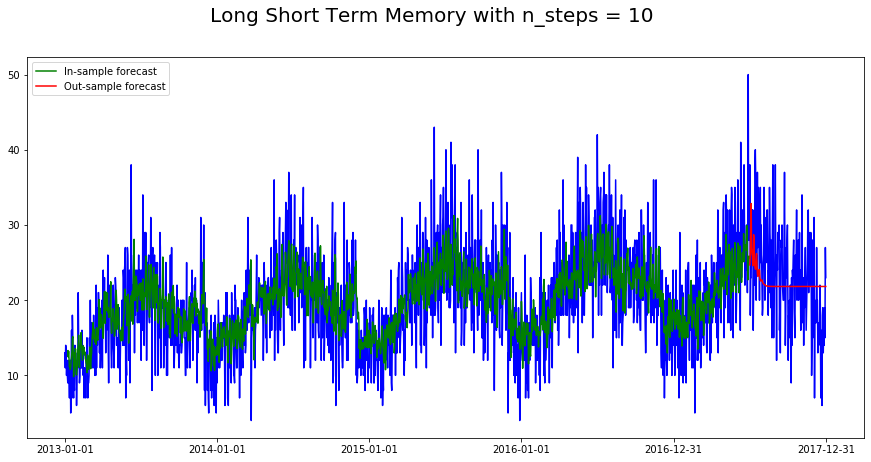

In [18]:
from numpy.random import seed
seed(1)

# Univariate stacked lstm
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

# Split a univariate sequence
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# Model configuration
n_steps = 7
raw_seq = train11.sales
X, y = split_sequence(raw_seq, n_steps)
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

lstm = Sequential()
lstm.add(LSTM(9, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
lstm.add(LSTM(9, activation='relu'))
lstm.add(Dropout(0.05))
lstm.add(Dense(1))

# Optimization
from keras.optimizers import Adam
adam = Adam(clipvalue=0.5) # To avoid gradient explosion
lstm.compile(optimizer = adam, loss='mean_squared_error')
lstm.fit(X, y, epochs=100, verbose=2)

# Forecast
preds = pd.DataFrame(columns=['raw11','step','inLSTM', 'trainLSTM', 'LSTM'])
preds.raw11 = raw11.sales
preds.loc[0:N-1,'trainLSTM'] = train11.sales

for i in range (0, N-n_steps): #In-sample forecast
  x_input = np.array(preds.loc[i:i+n_steps-1,'raw11'])
  x_input = x_input.reshape((1, n_steps, n_features))
  preds.loc[i+n_steps, 'step'] = i+n_steps   
  preds.loc[i+n_steps,'inLSTM'] = lstm.predict(x_input, verbose=0).flatten()[0]
  
for i in range (N, len(raw11)): #Out-sample forecast
  x_input = np.array(preds.loc[i-n_steps:i-1,'trainLSTM'])
  x_input = x_input.reshape((1, n_steps, n_features))
  preds.loc[i,'trainLSTM'] = preds.loc[i,'LSTM'] = lstm.predict(x_input, verbose = 0).flatten()[0]  

outsample_forecast_LSTM = preds.loc[N:,'LSTM']

# Error
rmse_train_LSTM = math.sqrt(sum((preds.loc[n_steps:N-1, 'inLSTM']-train11.loc[n_steps:,'sales'])**2)/N) #4.352483949025942
rmse_test_LSTM = math.sqrt(sum((preds.loc[N:,'LSTM']-test11.sales)**2)/(len(raw11)-N)) #7.034124914751039
mape_train_LSTM = 100*sum(abs((preds.loc[n_steps:N-1, 'inLSTM']-train11.loc[n_steps:,'sales'])/train11.loc[n_steps:,'sales']))/N #
mape_test_LSTM = 100*sum(abs((preds.loc[N:,'LSTM']-test11.sales)/test11.sales))/(len(raw11)-N) #
print('rmse_train_LSTM', rmse_train_LSTM)
print('rmse_test_LSTM', rmse_test_LSTM)
print('mape_train_LSTM', mape_train_LSTM)
print('mape_test_LSTM', mape_test_LSTM)

# Plot
plt.figure(figsize=(15,7))
plt.plot(raw11.date, raw11.sales, color = 'blue')
plt.plot(preds.inLSTM, label='In-sample forecast', color = 'green')
plt.plot(preds.LSTM, label='Out-sample forecast', color = 'red')
plt.legend()
plt.xticks(np.arange(0, len(raw11), 365))
plt.suptitle('Long Short Term Memory with n_steps = 10', fontsize = 20)
plt.savefig(path + 'LSTM_nsteps=10.jpg', dpi = 500)
plt.show()

# 60: 48.54872346001512
# 30: 20.560956684080804
# 15: 8.733966544864794
# 12: 7.68966323306075
# 11: 9.5826788486822
# 10: 6.63700341610319
# 9: 8.04535863965259
# 7: 7.527709369380126

## **Section 8. Hybridization**

rmse_test_TBATS_KNN 5.0036785503364705
mape_test_TBATS_KNN 21.304536597935936


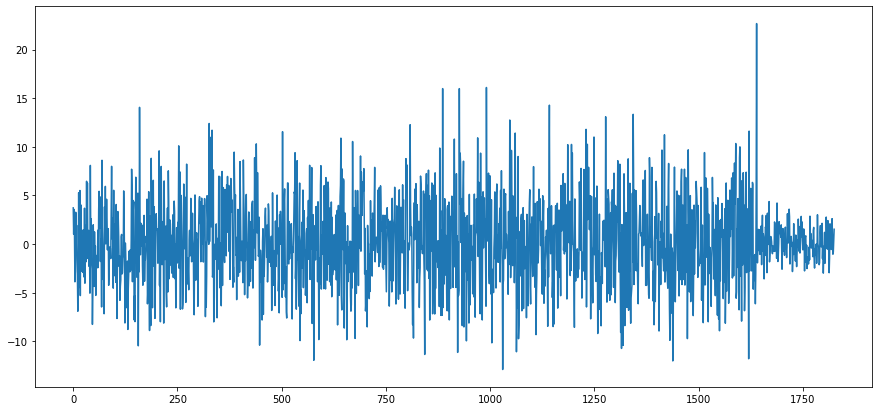

In [21]:
'''
KNN on residual of TBATS
'''

eTBATS = TBATS_result.resid

# Hyperparameters wsize and k turning
WSIZE = [365]
K = [7]
grid = pd.DataFrame(index=K, columns=WSIZE)

for wsize in WSIZE:
  for k in K:

    # Model configuration
    nnm = KNNRegressor(wsize = wsize, k = k, Minkowski_p = 2)
    preds = pd.DataFrame(columns=['eTBATS', 'eTBATS_KNN'])
    preds.eTBATS = eTBATS

    # Forecasting
    for i in range (N, len(raw11)):
      x_input = preds.loc[:i-1,'eTBATS']
      preds.loc[i,'eTBATS'] = preds.loc[i,'eTBATS_KNN'] = nnm.forecast(x_input)

# Error
outsample_forecast_TBATS_KNN = preds.loc[N:,'eTBATS_KNN'] + outsample_forecast_TBATS
rmse_test_TBATS_KNN = math.sqrt(sum((outsample_forecast_TBATS_KNN-test11.sales)**2)/(len(raw11)-N))
mape_test_TBATS_KNN = 100*sum(abs((outsample_forecast_TBATS_KNN-test11.sales)/test11.sales))/(len(raw11)-N) #
print('rmse_test_TBATS_KNN', rmse_test_TBATS_KNN)
print('mape_test_TBATS_KNN', mape_test_TBATS_KNN)

# Plot
plt.figure(figsize=(15,7))
plt.plot(preds.eTBATS)
plt.show()

# 4.709578222905581

422 rmse_test_eTBATS_SVR 4.651378790244477
422 mape_test_TBATS_SVR 19.775709688317324


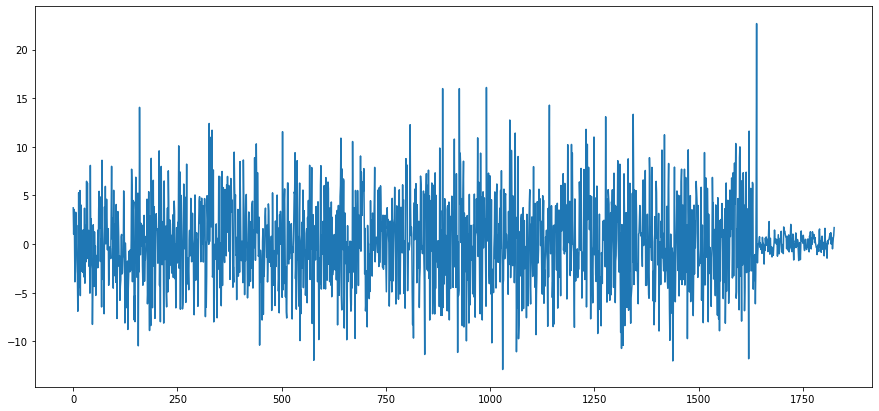

'\nTBATS: 4.709578222905581\n415 rmse_test_eTBATS_SVR 4.658875116733927\n416 rmse_test_eTBATS_SVR 4.658806671808871\n417 rmse_test_eTBATS_SVR 4.658145086704134\n418 rmse_test_eTBATS_SVR 4.657535104941293\n419 rmse_test_eTBATS_SVR 4.660347028332008\n420 rmse_test_eTBATS_SVR 4.660227359829793\n421 rmse_test_eTBATS_SVR 4.653545029391591\n422 rmse_test_eTBATS_SVR 4.651378790244477 ###\n423 rmse_test_eTBATS_SVR 4.6600700511295\n424 rmse_test_eTBATS_SVR 4.659534879404973\n425 rmse_test_eTBATS_SVR 4.659105686873499\n426 rmse_test_eTBATS_SVR 4.659546008376722\n427 rmse_test_eTBATS_SVR 4.657793929828801\n428 rmse_test_eTBATS_SVR 4.658931907320968\n429 rmse_test_eTBATS_SVR 4.657542686181605\n430 rmse_test_eTBATS_SVR 4.669068021538821\n431 rmse_test_eTBATS_SVR 4.673544522111476\n432 rmse_test_eTBATS_SVR 4.6776516039448435\n433 rmse_test_eTBATS_SVR 4.672920736358838\n434 rmse_test_eTBATS_SVR 4.670670770716904\n'

In [22]:
'''
SVR on residual of TBATS
'''

eTBATS = TBATS_result.resid

from numpy import array
from sklearn.svm import SVR

# Split a univariate sequence
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 

# Model configuration and optimization

for n_steps in range(422,423,1):
  raw_seq = eTBATS
  X, y = split_sequence(raw_seq, n_steps)
  svr = SVR(kernel='rbf', C=2, epsilon=0.1, gamma = 'scale', )
  svr.fit(X, y)

  # Forecast
  preds = pd.DataFrame(columns=['eTBATS', 'eTBATS_SVR'])
  preds.eTBATS = eTBATS

  for i in range (N-n_steps, len(raw11)-n_steps):
    x_input = np.array(preds.loc[i:i+n_steps-1,'eTBATS'])
    preds.loc[i+n_steps,'eTBATS'] = preds.loc[i+n_steps,'eTBATS_SVR'] = svr.predict(x_input.reshape(1,n_steps))


  # Error
  insample_forecast_TBATS_SVR = svr.predict(X)
  outsample_forecast_TBATS_SVR = preds.loc[N:,'eTBATS_SVR'] + outsample_forecast_TBATS
  rmse_test_TBATS_SVR = math.sqrt(sum((outsample_forecast_TBATS_SVR-test11.sales)**2)/(len(raw11)-N))
  mape_test_TBATS_SVR = 100*sum(abs((outsample_forecast_TBATS_SVR-test11.sales)/test11.sales))/(len(raw11)-N) #
  print(n_steps, 'rmse_test_eTBATS_SVR', rmse_test_TBATS_SVR) #4.651378790244477
  print(n_steps, 'mape_test_TBATS_SVR', mape_test_TBATS_SVR) 


# Plot
plt.figure(figsize=(15,7))
plt.plot(preds.eTBATS)
plt.show()

'''
TBATS: 4.709578222905581
415 rmse_test_eTBATS_SVR 4.658875116733927
416 rmse_test_eTBATS_SVR 4.658806671808871
417 rmse_test_eTBATS_SVR 4.658145086704134
418 rmse_test_eTBATS_SVR 4.657535104941293
419 rmse_test_eTBATS_SVR 4.660347028332008
420 rmse_test_eTBATS_SVR 4.660227359829793
421 rmse_test_eTBATS_SVR 4.653545029391591
422 rmse_test_eTBATS_SVR 4.651378790244477 ###
423 rmse_test_eTBATS_SVR 4.6600700511295
424 rmse_test_eTBATS_SVR 4.659534879404973
425 rmse_test_eTBATS_SVR 4.659105686873499
426 rmse_test_eTBATS_SVR 4.659546008376722
427 rmse_test_eTBATS_SVR 4.657793929828801
428 rmse_test_eTBATS_SVR 4.658931907320968
429 rmse_test_eTBATS_SVR 4.657542686181605
430 rmse_test_eTBATS_SVR 4.669068021538821
431 rmse_test_eTBATS_SVR 4.673544522111476
432 rmse_test_eTBATS_SVR 4.6776516039448435
433 rmse_test_eTBATS_SVR 4.672920736358838
434 rmse_test_eTBATS_SVR 4.670670770716904
'''

In [27]:
'''
TBATS on residual of SVR
'''

# Model configuration and optimization
SVR_TBATS_estimator = TBATS(use_box_cox = None, use_trend = None, use_damped_trend = None, seasonal_periods=(7, 365.25), use_arma_errors = True)
SVR_TBATS_result = SVR_TBATS_estimator.fit(eSVR)

# Forecast
outsample_forecast_SVR_TBATS = outsample_forecast_SVR + SVR_TBATS_result.forecast(steps=len(raw11)-N)

# Error
rmse_test_SVR_TBATS = math.sqrt(sum((outsample_forecast_SVR_TBATS-test11.sales)**2)/(len(raw11)-N)) #4.709578222905581
mape_test_SVR_TBATS = 100*sum(abs((outsample_forecast_SVR_TBATS-test11.sales)/test11.sales))/(len(raw11)-N) #

print('rmse_test_SVR_TBATS', rmse_test_SVR_TBATS) #4.744858442662186
print('mape_test_SVR_TBATS', mape_test_SVR_TBATS) #19.25307728733233

# # Plot
# plt.figure(figsize=(15,7))
# plt.plot(raw11.date, raw11.sales, color = 'blue')
# plt.plot(train11.date, insample_forecast_TBATS, label = 'In-sample forecast', color = 'green')
# plt.plot(test11.date, outsample_forecast_TBATS, label = 'Out-sample forecast', color = 'red')
# plt.legend()
# plt.xticks(np.arange(0, len(raw11), 365))
# plt.suptitle('TBATS model', fontsize = 20)
# plt.savefig(path + 'TBATS.jpg', dpi = 500)
# plt.show()

# # Model summary
# print(TBATS_result.summary())

# # Residual diagnostic
# plot_diagnostics(TBATS_result.resid)
# plt.suptitle('Residual diagnostic for TBATS model', fontsize = 20)
# plt.savefig(path + 'resid_TBATS.jpg', dpi = 500)
# plt.show()

rmse_test_SVR_TBATS 4.744858442662186
mape_test_SVR_TBATS 19.25307728733233


## **Section 9. Statistical tests**

pValue Chi-square [0.2367409  0.41220962 0.61638664 0.77354848 0.75646779 0.8440011
 0.80623816 0.73406733 0.79048178 0.81425379 0.86321797 0.90054907
 0.91877472 0.92177323 0.94811351 0.95227385 0.90821727 0.93542839
 0.94614431 0.96135002 0.96682977 0.97381863 0.9788722  0.96690575
 0.97705427 0.97405727 0.98011517 0.98424986 0.98831204 0.99201676
 0.55826423 0.56455952 0.6131957  0.66021342 0.69675672 0.43632378
 0.45559171 0.50036255 0.51022286 0.52757072]
DF (-39.33991724101603, 0.0, 0, 1642, {'1%': -3.4343387651403106, '5%': -2.8633018108486343, '10%': -2.5677079480625067}, 9446.753251889537)
BDS (array(0.47729678), array(0.63315081))


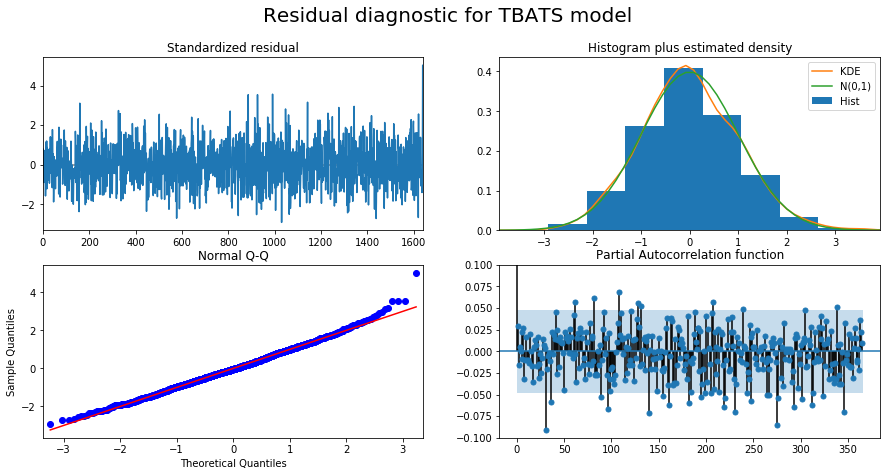

In [0]:
import statsmodels.stats.diagnostic as diag

# Ljung-Box test for autocorrelation
Ljung = diag.acorr_ljungbox(TBATS_result.resid, lags = 40)
print('pValue Chi-square', Ljung[1])
# Return The Ljung-Box test statistic (array) and The p-value based on chi-square distribution. 

# Augmented Dickey-Fuller unit root test
import statsmodels.tsa.stattools as stattools
DF = stattools.adfuller(TBATS_result.resid)
print('DF', DF)
# Return: 
  # adf: The test statistic
  # pvalue: MacKinnon’s approximate p-value based on MacKinnon (1994, 2010).
  # usedlag: The number of lags used.
  # nobs: The number of observations used for the ADF regression and calculation of the critical values.
  # critical values: Critical values for the test statistic at the 1 %, 5 %, and 10 % levels. Based on MacKinnon (2010).

# BDS Test Statistic for Independence of a Time Series and non-linearity
'''
The null hypothesis of the test statistic is for an independent and identically distributed (i.i.d.) time series, and an unspecified alternative hypothesis.
# https://faculty.washington.edu/ezivot/econ584/notes/nonlinear.pdf
'''
BDS = stattools.bds(TBATS_result.resid)
print('BDS', BDS)

  # bds_stat: The BDS statistic.
  # pvalue: The p-values associated with the BDS statistic.

# Residual diagnostic
plot_diagnostics(TBATS_result.resid, lags = 365)
plt.suptitle('Residual diagnostic for TBATS model', fontsize = 20)
plt.savefig(path + 'StatTest.jpg', dpi = 500)
plt.show()

In [0]:
# Author   : John Tsang
# Date     : December 7th, 2017
# Purpose  : Implement the Diebold-Mariano Test (DM test) to compare 
#            forecast accuracy
# Input    : 1) actual_lst: the list of actual values
#            2) pred1_lst : the first list of predicted values
#            3) pred2_lst : the second list of predicted values
#            4) h         : the number of stpes ahead
#            5) crit      : a string specifying the criterion 
#                             i)  MSE : the mean squared error
#                            ii)  MAD : the mean absolute deviation
#                           iii) MAPE : the mean absolute percentage error
#                            iv) poly : use power function to weigh the errors
#            6) poly      : the power for crit power 
#                           (it is only meaningful when crit is "poly")
# Condition: 1) length of actual_lst, pred1_lst and pred2_lst is equal
#            2) h must be an integer and it must be greater than 0 and less than 
#               the length of actual_lst.
#            3) crit must take the 4 values specified in Input
#            4) Each value of actual_lst, pred1_lst and pred2_lst must
#               be numerical values. Missing values will not be accepted.
#            5) power must be a numerical value.
# Return   : a named-tuple of 2 elements
#            1) p_value : the p-value of the DM test
#            2) DM      : the test statistics of the DM test
##########################################################
# References:
#
# Harvey, D., Leybourne, S., & Newbold, P. (1997). Testing the equality of 
#   prediction mean squared errors. International Journal of forecasting, 
#   13(2), 281-291.
#
# Diebold, F. X. and Mariano, R. S. (1995), Comparing predictive accuracy, 
#   Journal of business & economic statistics 13(3), 253-264.
#
##########################################################
def dm_test(actual_lst, pred1_lst, pred2_lst, h = 1, crit="MSE", power = 2):
    # Routine for checking errors
    def error_check():
        rt = 0
        msg = ""
        # Check if h is an integer
        if (not isinstance(h, int)):
            rt = -1
            msg = "The type of the number of steps ahead (h) is not an integer."
            return (rt,msg)
        # Check the range of h
        if (h < 1):
            rt = -1
            msg = "The number of steps ahead (h) is not large enough."
            return (rt,msg)
        len_act = len(actual_lst)
        len_p1  = len(pred1_lst)
        len_p2  = len(pred2_lst)
        # Check if lengths of actual values and predicted values are equal
        if (len_act != len_p1 or len_p1 != len_p2 or len_act != len_p2):
            rt = -1
            msg = "Lengths of actual_lst, pred1_lst and pred2_lst do not match."
            return (rt,msg)
        # Check range of h
        if (h >= len_act):
            rt = -1
            msg = "The number of steps ahead is too large."
            return (rt,msg)
        # Check if criterion supported
        if (crit != "MSE" and crit != "MAPE" and crit != "MAD" and crit != "poly"):
            rt = -1
            msg = "The criterion is not supported."
            return (rt,msg)  
        # Check if every value of the input lists are numerical values
        from re import compile as re_compile
        comp = re_compile("^\d+?\.\d+?$")  
        def compiled_regex(s):
            """ Returns True is string is a number. """
            if comp.match(s) is None:
                return s.isdigit()
            return True
        for actual, pred1, pred2 in zip(actual_lst, pred1_lst, pred2_lst):
            is_actual_ok = compiled_regex(str(abs(actual)))
            is_pred1_ok = compiled_regex(str(abs(pred1)))
            is_pred2_ok = compiled_regex(str(abs(pred2)))
            if (not (is_actual_ok and is_pred1_ok and is_pred2_ok)):  
                msg = "An element in the actual_lst, pred1_lst or pred2_lst is not numeric."
                rt = -1
                return (rt,msg)
        return (rt,msg)
    
    # Error check
    error_code = error_check()
    # Raise error if cannot pass error check
    if (error_code[0] == -1):
        raise SyntaxError(error_code[1])
        return
    # Import libraries
    from scipy.stats import t
    import collections
    import pandas as pd
    import numpy as np
    
    # Initialise lists
    e1_lst = []
    e2_lst = []
    d_lst  = []
    
    # convert every value of the lists into real values
    actual_lst = pd.Series(actual_lst).apply(lambda x: float(x)).tolist()
    pred1_lst = pd.Series(pred1_lst).apply(lambda x: float(x)).tolist()
    pred2_lst = pd.Series(pred2_lst).apply(lambda x: float(x)).tolist()
    
    # Length of lists (as real numbers)
    T = float(len(actual_lst))
    
    # construct d according to crit
    if (crit == "MSE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append((actual - p1)**2)
            e2_lst.append((actual - p2)**2)
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAD"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs(actual - p1))
            e2_lst.append(abs(actual - p2))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAPE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs((actual - p1)/actual))
            e2_lst.append(abs((actual - p2)/actual))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "poly"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(((actual - p1))**(power))
            e2_lst.append(((actual - p2))**(power))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)    
    
    # Mean of d        
    mean_d = pd.Series(d_lst).mean()
    
    # Find autocovariance and construct DM test statistics
    def autocovariance(Xi, N, k, Xs):
        autoCov = 0
        T = float(N)
        for i in np.arange(0, N-k):
              autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
        return (1/(T))*autoCov
    gamma = []
    for lag in range(0,h):
        gamma.append(autocovariance(d_lst,len(d_lst),lag,mean_d)) # 0, 1, 2
    V_d = (gamma[0] + 2*sum(gamma[1:]))/T
    DM_stat=V_d**(-0.5)*mean_d
    harvey_adj=((T+1-2*h+h*(h-1)/T)/T)**(0.5)
    DM_stat = harvey_adj*DM_stat
    # Find p-value
    p_value = 2*t.cdf(-abs(DM_stat), df = T - 1)
    
    # Construct named tuple for return
    dm_return = collections.namedtuple('dm_return', 'DM p_value')
    
    rt = dm_return(DM = DM_stat, p_value = p_value)
    
    return rt

In [0]:
from collections import OrderedDict 
forecast = OrderedDict([('outsample_forecast_sin', outsample_forecast_sin),
                        ('outsample_forecast_DHR', outsample_forecast_DHR),
                        ('outsample_forecast_TBATS', outsample_forecast_TBATS),
                        ('outsample_forecast_KNN', outsample_forecast_KNN),
                        ('outsample_forecast_SVR', outsample_forecast_SVR),
                        ('outsample_forecast_LSTM', outsample_forecast_LSTM),
                        ('outsample_forecast_TBATS_KNN', outsample_forecast_TBATS_KNN),
                        ('outsample_forecast_TBATS_SVR', outsample_forecast_TBATS_SVR),
                        ('outsample_forecast_SVR_TBATS', outsample_forecast_SVR_TBATS)
                        ])

for model1, forecast1 in forecast.items():
  for model2, forecast2 in forecast.items(): 
    if sum(forecast1 - forecast2) !=0:
      dm = dm_test(test11.sales, forecast1, forecast2, crit="MSE")
      print(model1, ', ', model2, ', ', dm[1])

outsample_forecast_sin ,  outsample_forecast_DHR ,  6.567388794026987e-08
outsample_forecast_sin ,  outsample_forecast_TBATS ,  8.141737630951337e-09
outsample_forecast_sin ,  outsample_forecast_KNN ,  2.9572888150663668e-05
outsample_forecast_sin ,  outsample_forecast_SVR ,  1.2545326653677356e-07
outsample_forecast_sin ,  outsample_forecast_LSTM ,  0.055358669129109944
outsample_forecast_sin ,  outsample_forecast_TBATS_KNN ,  4.262693315040082e-06
outsample_forecast_sin ,  outsample_forecast_TBATS_SVR ,  1.8275598797108234e-09
outsample_forecast_sin ,  outsample_forecast_SVR_TBATS ,  2.1462850524290472e-08
outsample_forecast_DHR ,  outsample_forecast_sin ,  6.567388794026987e-08
outsample_forecast_DHR ,  outsample_forecast_TBATS ,  0.05511383084020829
outsample_forecast_DHR ,  outsample_forecast_KNN ,  0.7184038393057288
outsample_forecast_DHR ,  outsample_forecast_SVR ,  0.6389206783303996
outsample_forecast_DHR ,  outsample_forecast_LSTM ,  1.0395876359160321e-08
outsample_forecast

In [31]:
for model1, forecast1 in forecast.items():
  for model2, forecast2 in forecast.items(): 
    if sum(forecast1 - forecast2) !=0:
      dm = dm_test(test11.sales, forecast1, forecast2, crit="MAPE")
      print(model1, ', ', model2, ', ', dm[1])

outsample_forecast_sin ,  outsample_forecast_DHR ,  1.8100371770161401e-06
outsample_forecast_sin ,  outsample_forecast_TBATS ,  6.7012129702462e-08
outsample_forecast_sin ,  outsample_forecast_KNN ,  1.5322083885288106e-06
outsample_forecast_sin ,  outsample_forecast_SVR ,  5.5846719641633964e-09
outsample_forecast_sin ,  outsample_forecast_LSTM ,  0.6895530919535027
outsample_forecast_sin ,  outsample_forecast_TBATS_KNN ,  3.518345002725133e-05
outsample_forecast_sin ,  outsample_forecast_TBATS_SVR ,  3.5267139691772075e-08
outsample_forecast_sin ,  outsample_forecast_SVR_TBATS ,  1.8763758466628704e-08
outsample_forecast_DHR ,  outsample_forecast_sin ,  1.8100371770161401e-06
outsample_forecast_DHR ,  outsample_forecast_TBATS ,  0.005785463594803919
outsample_forecast_DHR ,  outsample_forecast_KNN ,  0.01650954894633929
outsample_forecast_DHR ,  outsample_forecast_SVR ,  0.036999509993856754
outsample_forecast_DHR ,  outsample_forecast_LSTM ,  9.028457045114326e-06
outsample_forecas